# Dissertation - Study 1: Classical Application of NLP on Beige Books


By Charlie Smith, University of South Alabama

To do on July 26, 2024: Make sure calculations are correct of the classification metrics
    As it is, SMOTE balanced set doesn't seem to be performing much better
    I think it should; need further analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# read in bbNoText.csv as bbSimple
bbSimple = pd.read_csv("bbNoText_pop.csv")

# Replace Nan with 0
bbSimple.fillna(0, inplace=True)

# Change Date to datetime format
bbSimple['Date'] = pd.to_datetime(bbSimple['Date'])

In [33]:
# Check balance in bbSimple based on econ_index_change_dummy
print(bbSimple['econ_index_change_dummy'].value_counts())

econ_index_change_dummy
1    4011
0     689
Name: count, dtype: int64


In [34]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Split into testing and training datasets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(bbSimple, test_size=0.2, random_state=755)

# Divide up X and Y variables in testing and training sets
X_train = train_set.drop(columns=['econ_index_change_dummy','econ_index', 'econ_index_change','Year','District','file_name','Date'])
y_train = train_set['econ_index_change_dummy']
X_test = test_set.drop(columns=['econ_index_change_dummy','econ_index', 'econ_index_change','Year','District','file_name','Date'])
y_test = test_set['econ_index_change_dummy']

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=755)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

#cv_scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
#cv_predictions = cross_val_predict(model, X, y, cv=k)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred)
# Use predicted probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
# rounded to 2 decimal places
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("Specificity:", round(specificity, 2))
print("AUC:", round(auc, 2))
print("Confusion Matrix:")
print(conf_matrix)



Accuracy: 0.85
Precision: 0.87
Recall: 0.96
Specificity: 0.22
AUC: 0.78
Confusion Matrix:
[[ 31 111]
 [ 33 765]]


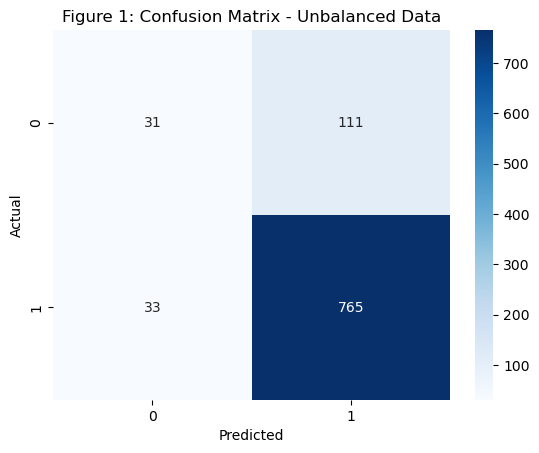

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 1: Confusion Matrix - Unbalanced Data")
#plt.savefig("confusion_matrix_unbalanced.png")
plt.show()


In [37]:
from sklearn.metrics import classification_report  # Use appropriate metrics for your problem

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Note weakness in predicting 0s, which is expected given the class imbalance


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.22      0.30       142
           1       0.87      0.96      0.91       798

    accuracy                           0.85       940
   macro avg       0.68      0.59      0.61       940
weighted avg       0.81      0.85      0.82       940



In [38]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities for each class
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, r_thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

# This is different than the ROC calculated above
    # Need to figure out which one is correct

0.7835830774118395


In [39]:
from sklearn.metrics import roc_auc_score

# Get the predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score}")

AUC: 0.7835830774118395


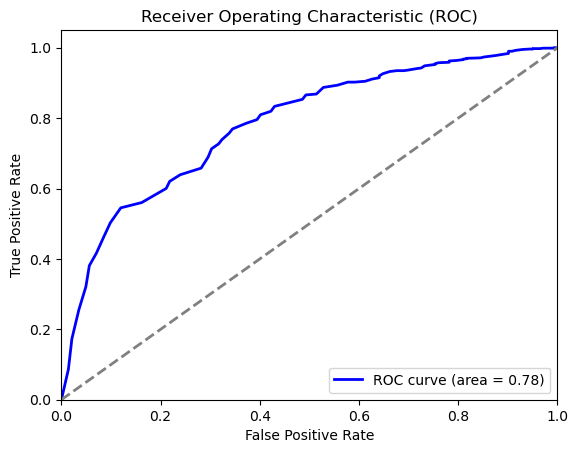

AUC: 0.7835830774118395


In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc}")


# Balanced dataset with SMOTE

In [41]:
# Use SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = bbSimple.drop(columns=['econ_index_change_dummy','econ_index', 'econ_index_change','Year','District','file_name','Date'])
y = bbSimple['econ_index_change_dummy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=755)

# Use SMOTE to balance the dataset
sm = SMOTE(random_state=755)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Create a new dataframe with the balanced dataset
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.DataFrame(y_res, columns=['econ_index_change_dummy'])

bbBalanced = pd.concat([X_res, y_res], axis=1)

In [42]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=755)

# Fit the model
model.fit(X_res, y_res)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate y_prob
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
# rounded to 2 decimal places
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("Specificity:", round(specificity, 2))
print("AUC:", round(auc, 2))
print("Confusion Matrix:")
print(conf_matrix)


C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_16592\2239328327.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_res, y_res)


Accuracy: 0.79
Precision: 0.91
Recall: 0.83
Specificity: 0.54
AUC: 0.78
Confusion Matrix:
[[ 76  66]
 [132 666]]


In [43]:
y_prob

array([0.92, 0.98, 0.69, 0.16, 0.82, 0.97, 0.99, 0.77, 0.89, 0.51, 0.76,
       0.84, 0.95, 0.88, 0.64, 0.57, 0.35, 0.82, 0.52, 0.67, 0.39, 0.4 ,
       0.16, 0.95, 0.59, 0.56, 0.99, 0.56, 0.96, 0.92, 0.98, 0.89, 0.89,
       0.96, 0.24, 0.99, 0.73, 0.95, 0.93, 0.27, 0.55, 0.05, 1.  , 0.99,
       0.17, 0.84, 0.79, 0.76, 0.99, 0.37, 0.71, 1.  , 0.48, 0.85, 0.07,
       0.36, 0.89, 0.61, 0.93, 0.99, 0.63, 0.95, 0.33, 0.73, 0.59, 0.19,
       0.9 , 0.59, 0.67, 0.61, 0.98, 0.87, 0.68, 0.89, 0.96, 0.92, 0.98,
       0.91, 0.84, 0.95, 0.86, 0.5 , 0.73, 0.63, 0.86, 0.35, 0.71, 0.97,
       0.11, 0.59, 0.87, 0.93, 0.7 , 0.56, 0.96, 0.91, 0.87, 0.44, 0.68,
       0.46, 0.68, 0.96, 0.54, 0.69, 0.43, 0.92, 0.91, 0.48, 0.67, 0.85,
       0.89, 0.24, 0.77, 0.87, 0.34, 0.47, 0.28, 0.92, 0.73, 0.64, 0.57,
       0.67, 0.71, 0.94, 0.96, 0.73, 0.87, 0.6 , 0.96, 0.83, 0.52, 0.62,
       0.82, 0.65, 0.97, 0.81, 0.98, 0.89, 0.99, 0.86, 0.88, 0.54, 0.51,
       0.94, 0.21, 0.93, 0.64, 0.96, 0.98, 0.97, 0.

In [44]:
from sklearn.metrics import classification_report  # Use appropriate metrics for your problem

class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Note better performance in predicting 0s after balancing the dataset


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.54      0.43       142
           1       0.91      0.83      0.87       798

    accuracy                           0.79       940
   macro avg       0.64      0.68      0.65       940
weighted avg       0.83      0.79      0.80       940



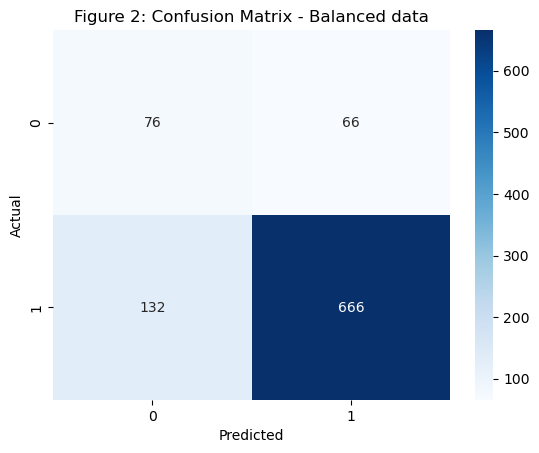

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 2: Confusion Matrix - Balanced data")
#plt.savefig("confusion_matrix_balanced.png")
plt.show()


In [46]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities for each class
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, r_thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7826829397437256


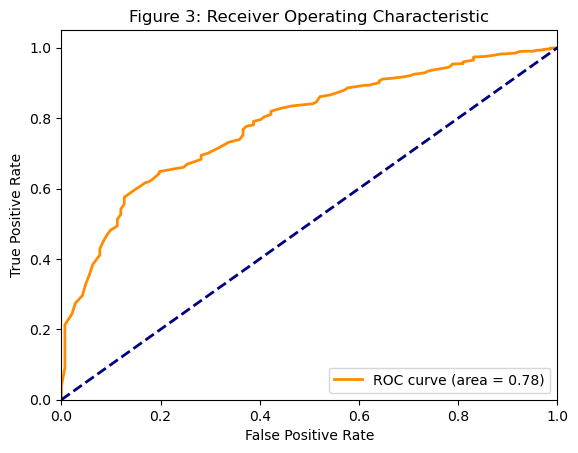

In [47]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 3: Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC_curve.png")
plt.show()

In [48]:
# Hyperparameter tuning
    # This takes about 3.5 minutes to run

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_res, y_res)

# Get the best model
best_model = grid_search.best_estimator_


KeyboardInterrupt: 

In [49]:
# Cross validation with SMOTE

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ('smote', SMOTE(random_state=755)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=755))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

print(f'Cross-validated AUC scores: {cv_scores}')
print(f'Mean AUC: {np.mean(cv_scores)}')


Cross-validated AUC scores: [0.65089089 0.64114623 0.6602154  0.52624327 0.81993619]
Mean AUC: 0.659686395542218


In [50]:
# ADASYN resampling instead of SMOTE

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=755)
X_res_ada, y_res_ada = adasyn.fit_resample(X_train, y_train)

# Fit the model with ADASYN resampled data
model.fit(X_res_ada, y_res_ada)

# Make predictions on the test set
y_pred_ada = model.predict(X_test)

# Calculate y_prob
y_prob_ada = model.predict_proba(X_test)[:, 1]

# Calculate additional metrics
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
specificity_ada = recall_score(y_test, y_pred_ada, pos_label=0)
recall_ada = recall_score(y_test, y_pred_ada)
auc_ada = roc_auc_score(y_test, y_prob_ada)
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)

# Print the metrics
# rounded to 2 decimal places
print("Accuracy:", round(accuracy_ada, 2))
print("Precision:", round(precision_ada, 2))
print("Recall:", round(recall_ada, 2))
print("Specificity:", round(specificity_ada, 2))
print("AUC:", round(auc_ada, 2))
print("Confusion Matrix:")
print(conf_matrix_ada)


Accuracy: 0.78
Precision: 0.91
Recall: 0.83
Specificity: 0.53
AUC: 0.78
Confusion Matrix:
[[ 75  67]
 [137 661]]


# Calculate optimal threshold

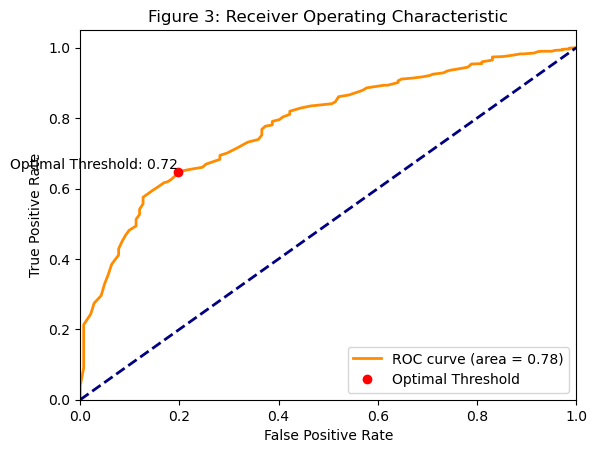

In [51]:
# Calculating Youden's J Statistic
    # J = Sensitivity + Specificity - 1
        # Could be written J = tpr - fpr
        # Because specificity = 1 - fpr
    # Higher values indicate better performance
    # Point on ROC that maximizes is often considered optimal
    # That is, maximizing the sum of sensitivity and specificity

# Calculate the Youden's J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = r_thresholds[optimal_idx]
optimal_J = J[optimal_idx]

# Plot the optimal point on the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 3: Receiver Operating Characteristic')

# Add the optimal threshold to the plot
plt.text(fpr[optimal_idx], tpr[optimal_idx], 'Optimal Threshold: {:.2f}'.format(optimal_threshold), 
         va='bottom', ha='right', color='black')

plt.legend(loc="lower right")
plt.savefig("ROC_curve_optimal.png")
plt.show()

In [53]:
# Recalcuate the model using the optimal threshold
y_pred_optimal = np.where(y_prob[:, 1] > optimal_threshold, 1, 0)

# Calculate probabilities
y_prob_optimal = model.predict_proba(X_test)[:, 1]

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
specificity = recall_score(y_test, y_pred_optimal, pos_label=0)
recall = recall_score(y_test, y_pred_optimal)
auc = roc_auc_score(y_test, y_prob_optimal)
conf_matrix = confusion_matrix(y_test, y_pred_optimal)

# Print the metrics
# rounded to 2 decimal places
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("Specificity:", round(specificity, 2))
print("AUC:", round(auc, 2))
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.67
Precision: 0.95
Recall: 0.64
Specificity: 0.8
AUC: 0.78
Confusion Matrix:
[[114  28]
 [285 513]]


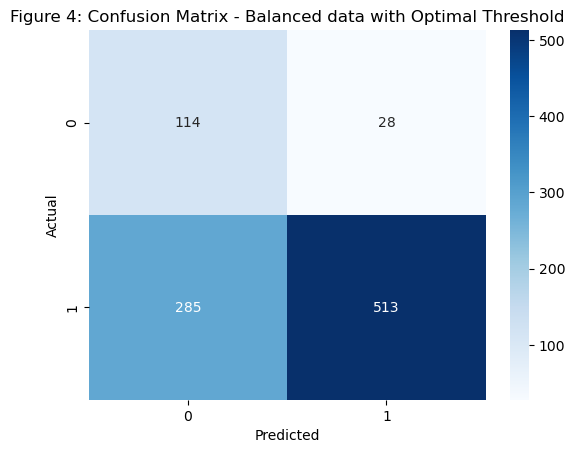

In [54]:
# Confusion matrix using optimal threshold
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Figure 4: Confusion Matrix - Balanced data with Optimal Threshold")
#plt.savefig("confusion_matrix_optimal.png")
plt.show()

# Feature Importance

C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_16592\776626450.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_res, y_res)


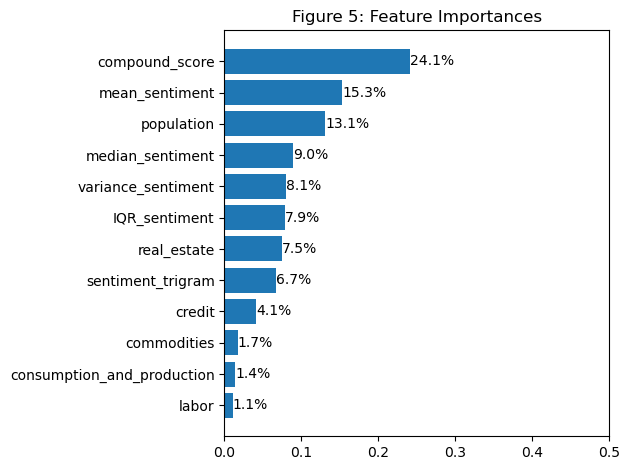

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
model.fit(X_res, y_res)

# Get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Figure 5: Feature Importances")
bars = plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlim([0, .5])

# Add labels to the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '{:.1f}%'.format(importance*100), 
             va='center', ha='left', color='black')

plt.tight_layout()  # Adjust layout to prevent cutting off
plt.savefig("Feature_importances_balanced.png", bbox_inches='tight')


plt.show()


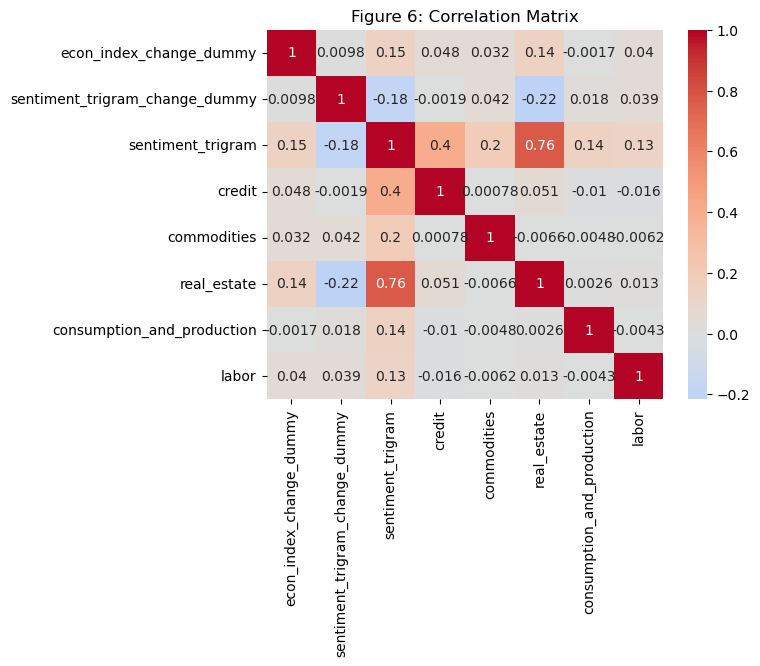

In [73]:
# Correlation matrix between sentiment_trigram, credit, commodities, real_estate, consumption_and_production, and labor

# Create a correlation matrix
corr = bbSimple[['econ_index_change_dummy', 'sentiment_trigram_change_dummy','sentiment_trigram', 'credit', 'commodities', 'real_estate', 'consumption_and_production', 'labor']].corr()

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Figure 6: Correlation Matrix")
#plt.savefig("Correlation_matrix.png")
plt.show()

<Axes: xlabel='Year'>

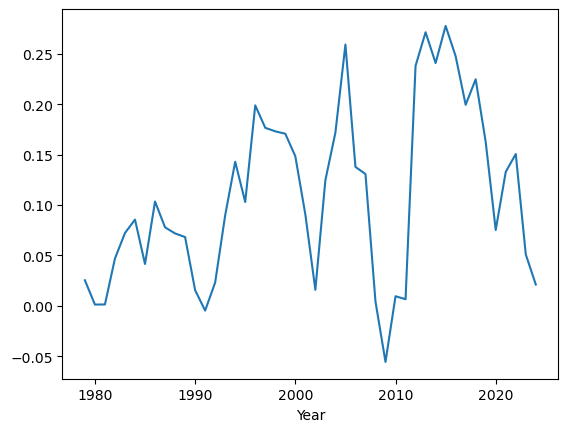

In [77]:
# Plot real estate over time
# Group by year and calculate the mean
real_estate = bbSimple.groupby('Year')['real_estate'].mean()

# Plot the real estate index over time
plt.figure()
real_estate.plot()


In [75]:
bbSimple.head()

,file_name,Date,Year,District,econ_index,econ_index_change,econ_index_change_dummy,compound_score,mean_sentiment,median_sentiment,...,sentiment_trigram,variance_sentiment,commodities,consumption_and_production,credit,labor,real_estate,sentiment_trigram_dummy,sentiment_trigram_change,sentiment_trigram_change_dummy
0,1979_bo (6).txt,1979-04-01,1979,1,47.886735,0.000000,0,0.8284,0.105670,0.0000,...,0.0000,0.191274,0.0,0.0,0.0000,0.0,0.0,0,NaN,0
1,1979_bo (5).txt,1979-06-01,1979,1,48.340812,0.948232,1,-0.3189,-0.003252,0.0000,...,0.0000,0.151537,0.0,0.0,0.0000,0.0,0.0,0,NaN,0
2,1979_bo (4).txt,1979-08-01,1979,1,48.628421,0.594960,1,-0.9199,-0.031011,0.0000,...,0.0000,0.270020,0.0,0.0,0.0000,0.0,0.0,0,NaN,0
3,1979_bo (3).txt,1979-09-01,1979,1,48.732335,0.213691,1,-0.9602,-0.024409,0.0258,...,0.6808,0.236339,0.0,0.0,0.6808,0.0,0.0,0,NaN,0
4,1979_bo (2).txt,1979-10-01,1979,1,48.829531,0.199447,1,0.9886,0.106649,0.0000,...,0.0000,0.212420,0.0,0.0,0.0000,0.0,0.0,0,NaN,0
